In [44]:
import json

ATTACK = 'other_attacks'
BENIGN = 'benign'

with open("../../data/pre_process/dissection_clean/5GCTD.json") as f:
    my_json = json.load(f)

total_dict = {
    BENIGN : [],
    ATTACK : [],
}

attack_list = set()

for dissected_pkt in my_json:

    is_attack = int(dissected_pkt["common"].pop("is_attack"))
    attack_type = dissected_pkt["common"]["type"]
    attack_list.add(attack_type)

    packet_dict = dissected_pkt["common"].copy()
    for protocols in dissected_pkt["protocols"].values():
        for layer in protocols:
            packet_dict.update(layer)

    label = BENIGN if not is_attack else ATTACK

    total_dict[label].append(packet_dict)

In [45]:
from datetime import datetime

ts_dict = {
    BENIGN : [],
    ATTACK : [],
    'applicative_scan' : [],
    'cn_mitm' : [],
    'flood_deletion' : [],
    'flood_etablishment' : [],
    'fuzz' : [],
    'seid_fuzzing' : []
}

for label in [BENIGN, ATTACK]:
    for packet in total_dict[label]:
        attack_type = packet.pop("type")

        ts = packet["ts"]
        ts = datetime.fromtimestamp(ts)

        if attack_type in ts_dict.keys():
            ts_dict[attack_type].append(ts)

        else :
            ts_dict[label].append(ts)

ts_dict["Benign"] = ts_dict.pop("benign")
ts_dict["Scan NFs"] = ts_dict.pop("applicative_scan")
ts_dict["CN MiTM"] = ts_dict.pop("cn_mitm")
ts_dict["Flood Deletion"] = ts_dict.pop("flood_deletion")
ts_dict["Flood Establishment"] = ts_dict.pop("flood_etablishment")
ts_dict["Fuzzing API"]  = ts_dict.pop("fuzz")
ts_dict["Seid Fuzzing"] = ts_dict.pop("seid_fuzzing")
ts_dict["Other Attacks"] = ts_dict.pop("other_attacks")



C:\Users\thoger\AppData\Local\Temp\ipykernel_16568\1435347694.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(counts.columns))


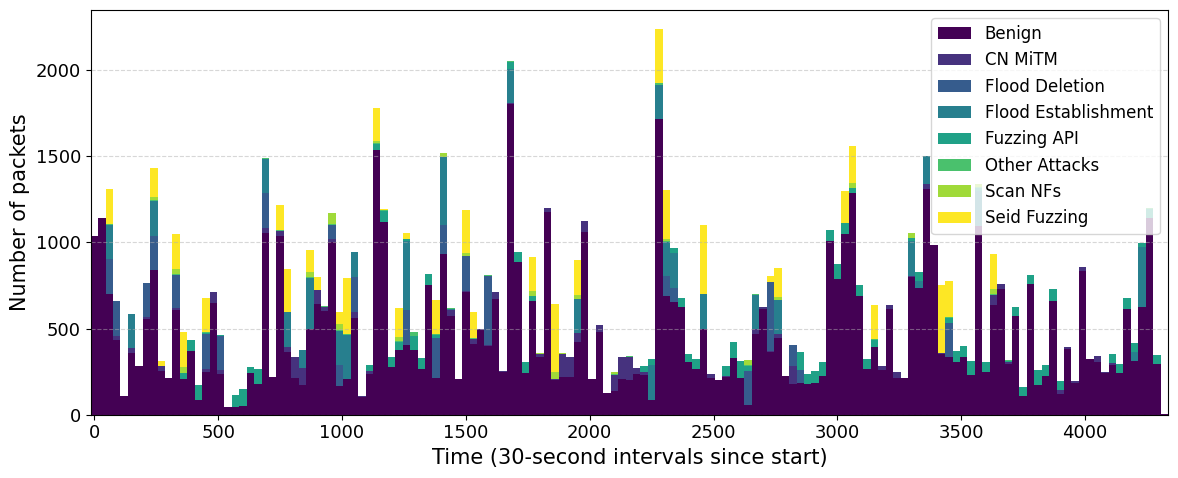

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    'font.size': 14,          # Taille de base du texte
    'axes.titlesize': 16,     # Taille du titre de l’axe
    'axes.labelsize': 15,     # Taille des labels x/y
    'xtick.labelsize': 13,    # Taille des ticks de l’axe X
    'ytick.labelsize': 13,    # Taille des ticks de l’axe Y
    'legend.fontsize': 12,    # Taille de la légende
})

# 1️⃣ Construire un DataFrame global
dfs = []
for key, timestamps in ts_dict.items():
    if len(timestamps) == 0:
        continue
    df_temp = pd.DataFrame({'time': pd.to_datetime(timestamps), 'source': key})
    dfs.append(df_temp)

if not dfs:
    print("Aucune donnée à afficher.")
else:
    df = pd.concat(dfs)

    # 2️⃣ Grouper par tranches de 5 secondes
    df['bin'] = ((df['time'] - df['time'].min()).dt.total_seconds() // 30 * 30).astype(int)

    # 3️⃣ Compter les occurrences par 'bin' et 'source'
    counts = df.groupby(['bin', 'source']).size().unstack(fill_value=0)

    # 4️⃣ Tracer en barres empilées
    plt.figure(figsize=(12, 5))

    colors = plt.cm.get_cmap('viridis', len(counts.columns))
    # color_list = ['silver'] + [colors(i) for i in range(1, len(counts.columns))]
    color_list = [colors(i) for i in range(0, len(counts.columns))]

    bottom = np.zeros(len(counts))
    for i, col in enumerate(counts.columns):
        plt.bar(counts.index, counts[col], width=30, bottom=bottom, label=col, color=color_list[i])
        bottom += counts[col].values

    # 5️⃣ Mise en forme du graphique
    plt.xlabel("Time (30-second intervals since start)")
    plt.ylabel("Number of packets")
    # plt.title("Packet count comparison per 30-second interval")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # 🔧 Ajustements demandés :
    plt.margins(x=0)   # Supprime les marges verticales inutiles
    plt.tight_layout()
    plt.show()


C:\Users\thoger\AppData\Local\Temp\ipykernel_16568\3826097256.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(counts.columns))


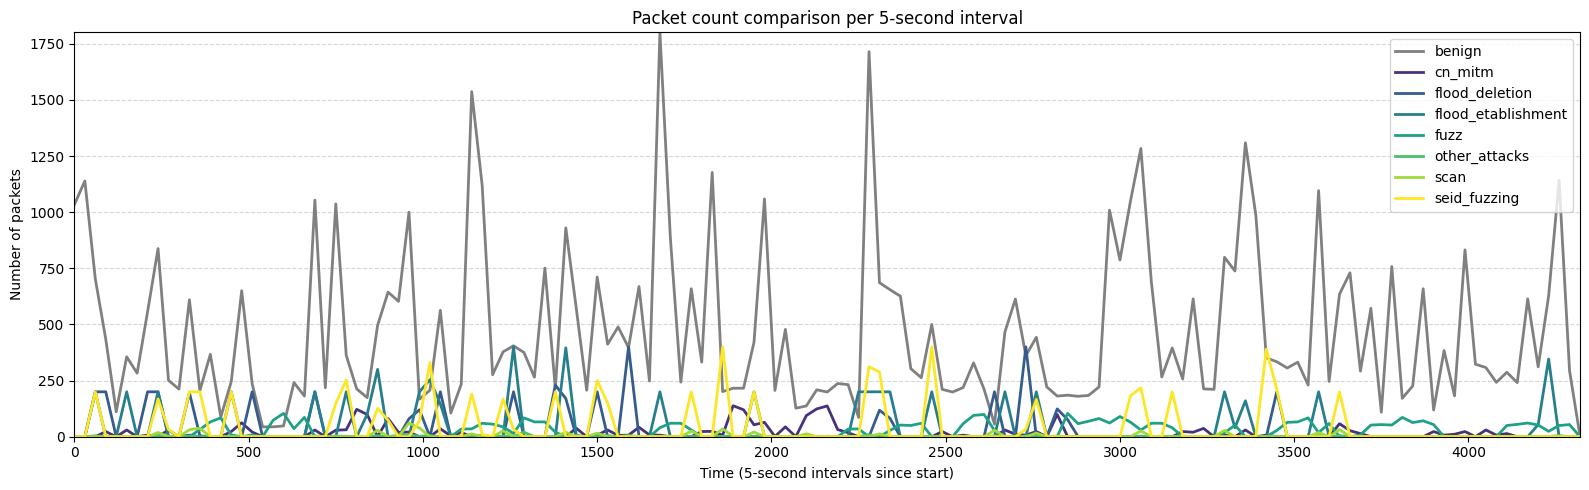

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

dfs = []
for key, timestamps in ts_dict.items():
    if len(timestamps) == 0:
        continue
    df_temp = pd.DataFrame({'time': pd.to_datetime(timestamps), 'source': key})
    dfs.append(df_temp)

if not dfs:
    print("Aucune donnée à afficher.")
else:
    df = pd.concat(dfs)

    # Grouper par tranches de 5 secondes
    df['bin'] = ((df['time'] - df['time'].min()).dt.total_seconds() // 30 * 30).astype(int)

    # Compter les occurrences
    counts = df.groupby(['bin', 'source']).size().unstack(fill_value=0)
    
    # if 'benign' in counts.columns:
    #     counts = counts.drop(columns='benign')

    # Générer les couleurs (première = gris)
    cmap = plt.cm.get_cmap('viridis', len(counts.columns))
    color_list = ['gray'] + [cmap(i) for i in range(1, len(counts.columns))]

    # Tracer les courbes
    plt.figure(figsize=(16, 5))
    for i, col in enumerate(counts.columns):
        plt.plot(counts.index, counts[col],
                 label=col,
                 color=color_list[i],
                 linewidth=2)

    # Mise en forme
    plt.xlabel("Time (5-second intervals since start)")
    plt.ylabel("Number of packets")
    plt.title("Packet count comparison per 5-second interval")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.margins(y=0)
    plt.margins(x=0)    # colle la base à 0
    plt.tight_layout()
    plt.show()
